In [1]:
import pandas as pd 
import nltk
from pathlib import Path
import re
import string
import requests
from nltk import sent_tokenize
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

## Introduction

 
 For this project we are going to use NLP and network grpahs to analyze the Game Of Thrones books.  All book files have been uploaded to github here: https://github.com/justinherman42/Data620/tree/master/GOT_Final_project/textfiles
 
 The text files were edited by hand. The books are ordered in chronological order.  We verified the first and last sentences via https://bookatlas.wordpress.com/books-a-z/ .  The website displays the first and last sentence of all of the books.  

In [2]:
def clean_text(text_file):    
    '''
    Reads in text file from GITHUB gets rid of newline and special characters
    '''
    
    url = 'https://raw.githubusercontent.com/justinherman42/Data620/master/GOT_Final_project/textfiles/'+text_file
    page = requests.get(url)
    text=page.text
    data = text.replace('\r', ' ').replace('\n', ' ').replace("\'", "'")   
    novel=''
    novel += ' ' + data
    novel = novel.replace('. . .',';')
    return novel



## Store text in dictionary
+ Built out dictionary with untokenized data for the Count Vectorizer
+ All I really saw in terms of issues was '...' being frequently used in the books.  Obviously this messed with the tokenizer, so i replaced it with  ; in the clean text function above.  

In [3]:

## build out names for text file URL's
git_text_file_names=['got1.txt','got2.txt','got3.txt','got4.txt','got5.txt']

## Built out dictionary with untokenized data to use with the count vectorizer
## All I really saw in terms of issues was ... being frequently used which I substituted with ;

book_series_untokenized={}
for i,x in enumerate(git_text_file_names):
    book_series_untokenized["book{}".format(i+1)]=clean_text(x)

## built out dictionary with tokenized data
book_series={}
for i,x in enumerate(git_text_file_names):
    orig_text=clean_text(x)
    sentence_list = sent_tokenize(orig_text)
    book_series["book{}".format(i+1)]= sentence_list



In [4]:
type(book_series["book1"])

list

## Name Entity Recognition

We'll use the SpaCY library for name recognition.

In [5]:
#Instantiate NLP for English
nlp = spacy.load('en')

In [6]:

def name_entity_recognition(sentence):
    '''
    A function to retrieve name entities in a sentence.
    :param sentence: the sentence to retrieve names from.
    :return: a name entity list of the sentence.
    '''

    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON']]
    # convert all names to lowercase and remove 's and ’s in names
    name_entity = [str(x).lower().replace("'s","") for x in name_entity]
    name_entity = [x.replace("’s","") for x in name_entity]
    # remove name words that are less than 3 letters to raise recognition accuracy
    name_entity = [x for x in name_entity if len(x) >= 3]

    return name_entity



In [7]:
def flatten(l):
    """A function that flattens a complex list"""
    flat_list = []
    for i in l:
        for j in i:
            flat_list.append(j)
    return flat_list

In [8]:
def nlist(book):
    """Returns a unique list of names from a sentence tokenized book"""
    names = []
    for i in book:
        if name_entity_recognition(i) != []:
            names.append(name_entity_recognition(i))
    names = list(set(flatten(names)))
    return names

In [10]:
names_book1 = nlist(book_series["book1"])
names_book2 = nlist(book_series["book2"])
names_book3 = nlist(book_series["book3"])
names_book4 = nlist(book_series["book4"])
names_book5 = nlist(book_series["book5"])

In [11]:
all_names_list = [names_book1,names_book2,names_book3,names_book4,names_book5]

# As shown below, for some unknown reason SpaCy NER was unable to detect Tyrion as a name entity
# in a few of the books
for i in all_names_list:
    print('tyrion' in i)

# We will manually enter Tyrion in for books 1, 2, and 4
names_book1.append('tyrion')
names_book2.append('tyrion')
names_book4.append('tyrion')

False
False
True
False
True


### Notes on Names in GOT
Created a list called `words` to remove words that the NER algorithm is mistakenly catching as name entities. Game of Thrones names are tricky and there are a few times where major characters in the books names can change and how they're referenced. We can keep the names separate and see how sentiment changes and even reveal how different the relationships can be when the characters are referenced under their alias.

- Arya
 - Sometime in Book 4, Arya begins her training at the House of Black and White. She is called "Girl" from here moving forward.
- Jon Snow
 - Good to know that usually when Jon Snow is called Jon in the book, it's in a positive light. When he's called "Snow", it's often in a negative one. Would be interesting to see the sentiment analysis confirm this.
- Dany
 - Also known as Daenarys
- Ned Stark
 - Also known as Eddard
- Pie
 - Hot Pie. 


In [12]:
""" We'll load certain words that SpaCy NER pulled as names that are not names to extricate them 
from the list. Game of Thrones names are tricky and it's helpful that some members of our group have 
read the books to be able to recognize some things as not names. For example, Pie is a character, but 
could easily be mistaken as the food.
"""
words = ['hand','father','maester','gods','winterfell','wine','uncle','sleep','broken',
        'wall','battle','watch','sweet','killed','north','child','kill','harrenhal','rock',
         'dothraki','dead','ser','blood','knew','sword','queen','wolf','words','horse','hands',
         'fingers','left','wildlings','daughter','word','fat','bastard','westeros','light',
         'yunkai','aye','meereen','knight','woman','gate',
         'lady', #removing lady. Although Lady is Sansa's wolf, Lady dies early and the NER algorithm
                 # continues to pick up lady due to it's use as in "Lady Stark", etc.
         'grace'] #removing grace since this person changes based on who sits on the iron throne
                


We'll only pull the top 25 characters by frequency to review in our analysis

In [13]:
def top_names(name_list, novel, top_num=25):
    '''
    Returns name freq of a book for each name
    '''

    vect = CountVectorizer(vocabulary=name_list, stop_words='english')
    name_frequency = vect.fit_transform([novel.lower()])
    name_frequency = pd.DataFrame(name_frequency.toarray(), columns=vect.get_feature_names())
    name_frequency = name_frequency.T
    name_frequency = name_frequency.sort_values(by=0, ascending=False)
    name_frequency = name_frequency[0:top_num]
    names = list(name_frequency.index)
    name_frequency = list(name_frequency[0])

    return name_frequency, names

In [34]:
names1 = [x for x in names_book1 if x not in words]
names2 = [x for x in names_book2 if x not in words]
names3 = [x for x in names_book3 if x not in words]
names4 = [x for x in names_book4 if x not in words]
names5 = [x for x in names_book5 if x not in words]

def out_freq_df(name_freq):
    """Takes the items returned from top_names and returns a dataframe that will be fed into viz"""
    df = pd.DataFrame([name_freq[1],name_freq[0]]).transpose()
    df.columns = ['names','freq']
    return df

topnames1_df = out_freq_df(top_names(names1,book_series_untokenized['book1']))
topnames2_df = out_freq_df(top_names(names2,book_series_untokenized['book2']))
topnames3_df = out_freq_df(top_names(names3,book_series_untokenized['book3']))
topnames4_df = out_freq_df(top_names(names4,book_series_untokenized['book4']))
topnames5_df = out_freq_df(top_names(names5,book_series_untokenized['book5']))

In [49]:
def name_freq_plot(df,title):
    """plot for name freq"""
    sns.barplot(data=df, 
                y=df.names, 
                x=df.freq,
                color='blue')
    plt.title(title)
    plt.show()

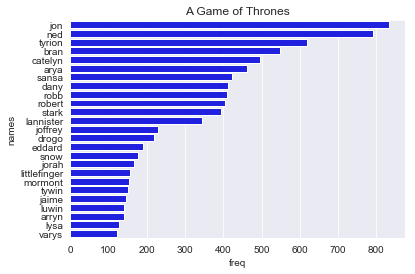

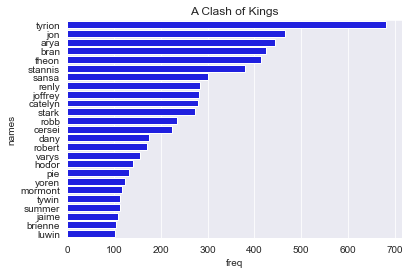

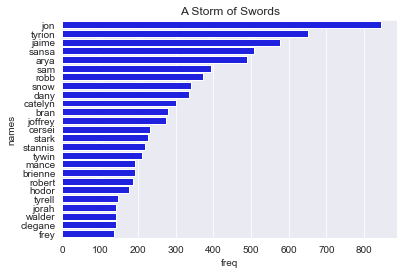

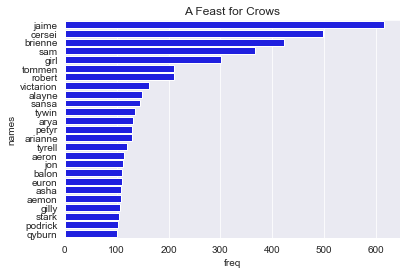

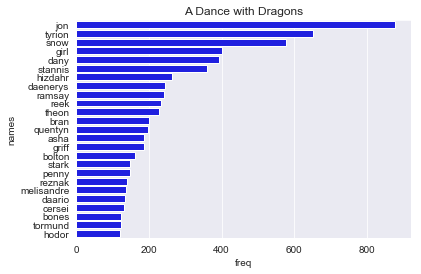

In [51]:
name_freq_plot(topnames1_df,'A Game of Thrones')
name_freq_plot(topnames2_df,'A Clash of Kings')
name_freq_plot(topnames3_df,'A Storm of Swords')
name_freq_plot(topnames4_df,'A Feast for Crows')
name_freq_plot(topnames5_df,'A Dance with Dragons')